In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.cm as cm
from empath import Empath
import seaborn as sns
import json
import math
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sys
import pickle as pkl
import pyLDAvis
import pyLDAvis.gensim
import operator
import networkx as nx
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout
import random
import powerlaw
import copy

In [2]:
#Use Keys of this dictionary as primary keys 
census_SW = json.load(open("SW_triadic_census_v2.json",'r'))
census_BL = json.load(open("BL_triadic_census_v2.json",'r'))

In [3]:

Allgraphs_SW = "../Data/SW_TopicReplygraphs_Cosine_V2.pkl"
Allgraphs_BL = "../Data/BL_TopicReplygraphs_Cosine_V2.pkl"
allGraphs_SW = pkl.load(open(Allgraphs_SW,'rb'))
allGraphs_BL = pkl.load(open(Allgraphs_BL,'rb'))

In [4]:
SW_Graphs= pkl.load(open("../Data/SW_TopicUgraphs_Cosine_V2.pkl",'rb'))
BL_Graphs= pkl.load(open("../Data/BL_TopicUgraphs_Cosine_V2.pkl",'rb'))

In [5]:
def getRootauthors(replyGraphs):
    rootAuthors = {}
    for k in replyGraphs:
        g = replyGraphs[k]
        for node in g:
            if 'depth' in g.node[node]:
                if g.node[node]['depth'] == -1:
                    rootAuthors[k] =  g.node[node]['author']
    return rootAuthors

def findTopicalEdgeWeight(graph,nodes):
    weightList = []
    for u,v,d in graph.edges(data=True):
        if (u in nodes or v in nodes):
            weightList.append(d['weight'])
    if len(weightList) > 0:
        return np.median(weightList)
    else:
        print "Did not find a single OP post, Weird :/"
        return None

def getTopologyMetrics(graphDict,keys, opDict=None):
    medCentralities = {}
    opCentrality = {}
    for k in keys:
        if k in graphDict.keys():
            centralities = nx.closeness_centrality(graphDict[k].to_undirected())
            medCentrality = np.median(centralities.values())
            if opDict:
                if k in opDict and opDict[k] in centralities:
                    if opDict[k] == '[deleted]':
                        print "op was Deleted"
                    else:
                        opCentrality[k] = centralities[opDict[k]]
                else:
                    print "Opdict does not have user for graphs"
            else:
                print "no opDict supplied"
            if np.isnan(medCentrality):
                print "Found Nan centrality"
                continue
            else:
                medCentralities[k] = medCentrality
            
    return  medCentralities , opCentrality

def getTopicMetrics(graphDict, keys, opDict = None):
    alignments = {}
    medianAlignments = {}
    for k in keys:
        if k in graphDict:
            alignment = 0.0
            medianAlignment = 0.0
            
            medianAlignment = findTopicalEdgeWeight(graphDict[k] , graphDict[k].nodes())
            if k in opDict:
                alignment = findTopicalEdgeWeight(graphDict[k] , opDict[k])
                alignments[k] = alignment
                medianAlignments[k] = medianAlignment
            else: 
                print "op Not Found!"
                
    return alignments, medianAlignments

In [6]:
SW_OpAuthors = getRootauthors(allGraphs_SW)
BL_OpAuthors = getRootauthors(allGraphs_BL)

In [7]:
# with(open("SW_OpAuthors_2.pkl",'rb')) as f:
#     SW_OpAuthors = pkl.load(f)

# with(open("BL_OpAuthors_2.pkl",'rb')) as f:
#     BL_OpAuthors = pkl.load(f)

In [7]:
len(SW_Graphs) , len(BL_Graphs)

(10527, 11070)

In [8]:
medianCentrality_SW, opCentrality_SW = getTopologyMetrics(SW_Graphs,census_SW.keys() , SW_OpAuthors  )

In [9]:
medianCentrality_BL, opCentrality_BL = getTopologyMetrics(BL_Graphs,census_BL.keys() ,BL_OpAuthors)

In [10]:
len(opCentrality_BL),len(medianCentrality_BL)

(11070, 11070)

In [11]:
len(opCentrality_SW),len(medianCentrality_SW)

(9857, 9857)

In [12]:
SW_opAlignment, SW_medAlignment = getTopicMetrics(SW_Graphs,census_SW.keys() , SW_OpAuthors)

In [13]:
len(SW_opAlignment) , len(SW_medAlignment)

(9857, 9857)

In [14]:
BL_opAlignment, BL_medAlignment = getTopicMetrics(BL_Graphs,census_BL.keys() , BL_OpAuthors)

In [21]:
len(BL_opAlignment) , len(BL_medAlignment)

(11070, 11070)

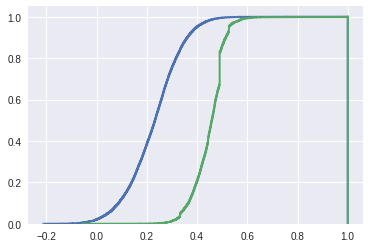

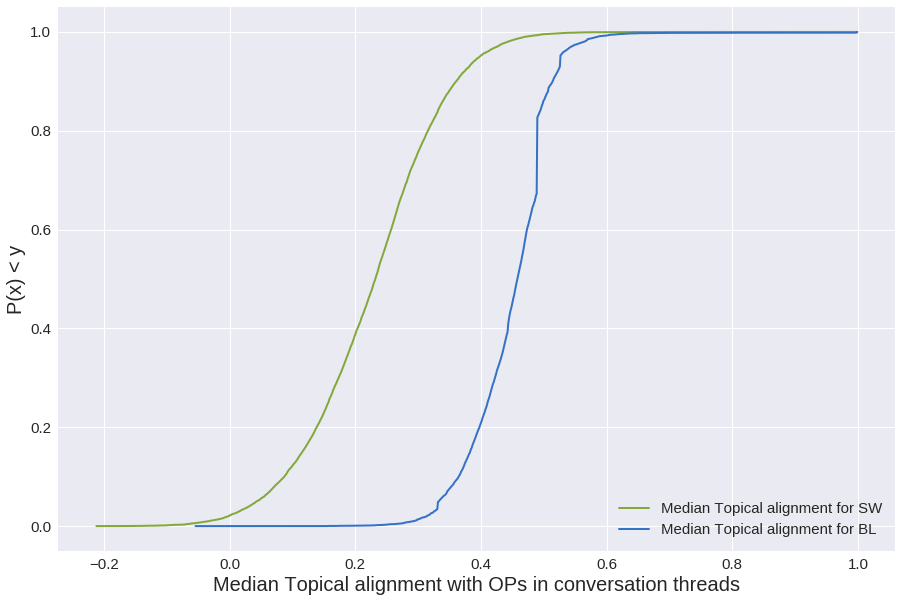

In [22]:
n1 , bins1 , patches1 = plt.hist(SW_medAlignment.values(), 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n2 , bins2 , patches2 = plt.hist(BL_medAlignment.values(), 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.plot(bins1[:-1], n1, 'g', linewidth=2)
ax.plot(bins2[:-1], n2, 'b', linewidth=2)

# plt.title("Clustering of User interaction Graphs", fontsize = 20)
plt.xlabel("Median Topical alignment with OPs in conversation threads",fontsize = 20)
plt.ylabel("P(x) < y",fontsize = 20)
plt.legend(['Median Topical alignment for SW','Median Topical alignment for BL'], loc='lower right',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.grid()
plt.show()

In [16]:
commonkeys_BL = [k for k in BL_Graphs.keys() if k in opCentrality_BL.keys() and k in BL_opAlignment.keys()]
print len(commonkeys_BL)

commonkeys_SW = [k for k in SW_Graphs.keys() if k in opCentrality_SW.keys() and k in SW_opAlignment.keys()]
print len(commonkeys_SW)

11070
9857


In [18]:
sampled_BL = random.sample(commonkeys_BL , len(commonkeys_SW))

In [19]:
def getMotifArray(dictValue):
    triadNames = ['003', '012', '102', '021D', '021U', '021C', '111D', '111U','030T', '030C', '201', '120D', '120U', '120C', '210', '300']
    motifCount = []
    denom = float(sum(dictValue.values()))
    for k in triadNames:
        motifCount.append(float(dictValue[k])/float(denom))
    return motifCount

In [23]:
BL_branching = pkl.load(open("SavedObjs/branching_BL.pkl",'rb'))
SW_branching = pkl.load(open("SavedObjs/branching_SW.pkl",'rb'))

In [30]:
featureMatrix = []
for k in sampled_BL:
    featList = getMotifArray(census_BL[k]) + [len(BL_Graphs[k].nodes()), medianCentrality_BL[k],opCentrality_BL[k] , BL_medAlignment[k] , BL_opAlignment[k] , BL_branching[k][0]] + [0]
    featureMatrix.append(featList)
print len(featureMatrix)

9857


In [31]:
for k in commonkeys_SW:
    featList = getMotifArray(census_SW[k]) + [len(SW_Graphs[k].nodes()) , medianCentrality_SW[k],opCentrality_SW[k] , SW_medAlignment[k] , SW_opAlignment[k] , SW_branching[k][0]] + [1]    
    featureMatrix.append(featList)
print len(featureMatrix)

19714


In [32]:
featMat = np.vstack(featureMatrix)
featMat.shape

(19714, 23)

In [33]:
np.random.shuffle(featMat)

In [34]:
featMat[:,:-1].shape

(19714, 22)

In [35]:
from sklearn import cross_validation
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier 
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support

In [36]:
 X_train, X_test, y_train, y_test = cross_validation.train_test_split(featMat[:,:-1], featMat[:,-1], test_size=0.2, random_state=0)

In [37]:
clfRF = RandomForestClassifier(n_estimators=1000 , max_features = 'sqrt', random_state = 9386, n_jobs=10)
clfRF.fit(X_train, y_train)
RF_predict = clfRF.predict(X_test)


accuracy = np.mean(y_test == RF_predict)
print accuracy
precision , recall , fscore , _ = precision_recall_fscore_support(y_test, RF_predict, average='binary')
print precision, recall, fscore
        


0.9680446360639108
0.9662404092071611 0.9692149820420729 0.9677254098360656


In [38]:
print clfRF.feature_importances_

[0.04041628 0.03615416 0.01570694 0.00434147 0.02298035 0.079919
 0.01667782 0.02291414 0.00257155 0.0007471  0.02802165 0.00096889
 0.00139294 0.00104862 0.00251139 0.00075992 0.0855336  0.13221075
 0.06215484 0.19220916 0.23267548 0.01808394]


In [41]:
names = ['003', '012', '102', '021D', '021U', '021C', '111D', '111U','030T', '030C', '201', '120D', '120U', '120C', '210', '300' , 'Number of Nodes', 'Median Centrality' ,'OP Centrality' , 'Median Topical alignment' , 'OP topical Alignment' , 'Mean Branching factor' ]     
coef_indices = np.argsort(clfRF.feature_importances_)[::-1]
Xlabel = [names[l] for l in coef_indices]
YFreq = [clfRF.feature_importances_[l] for l in coef_indices]

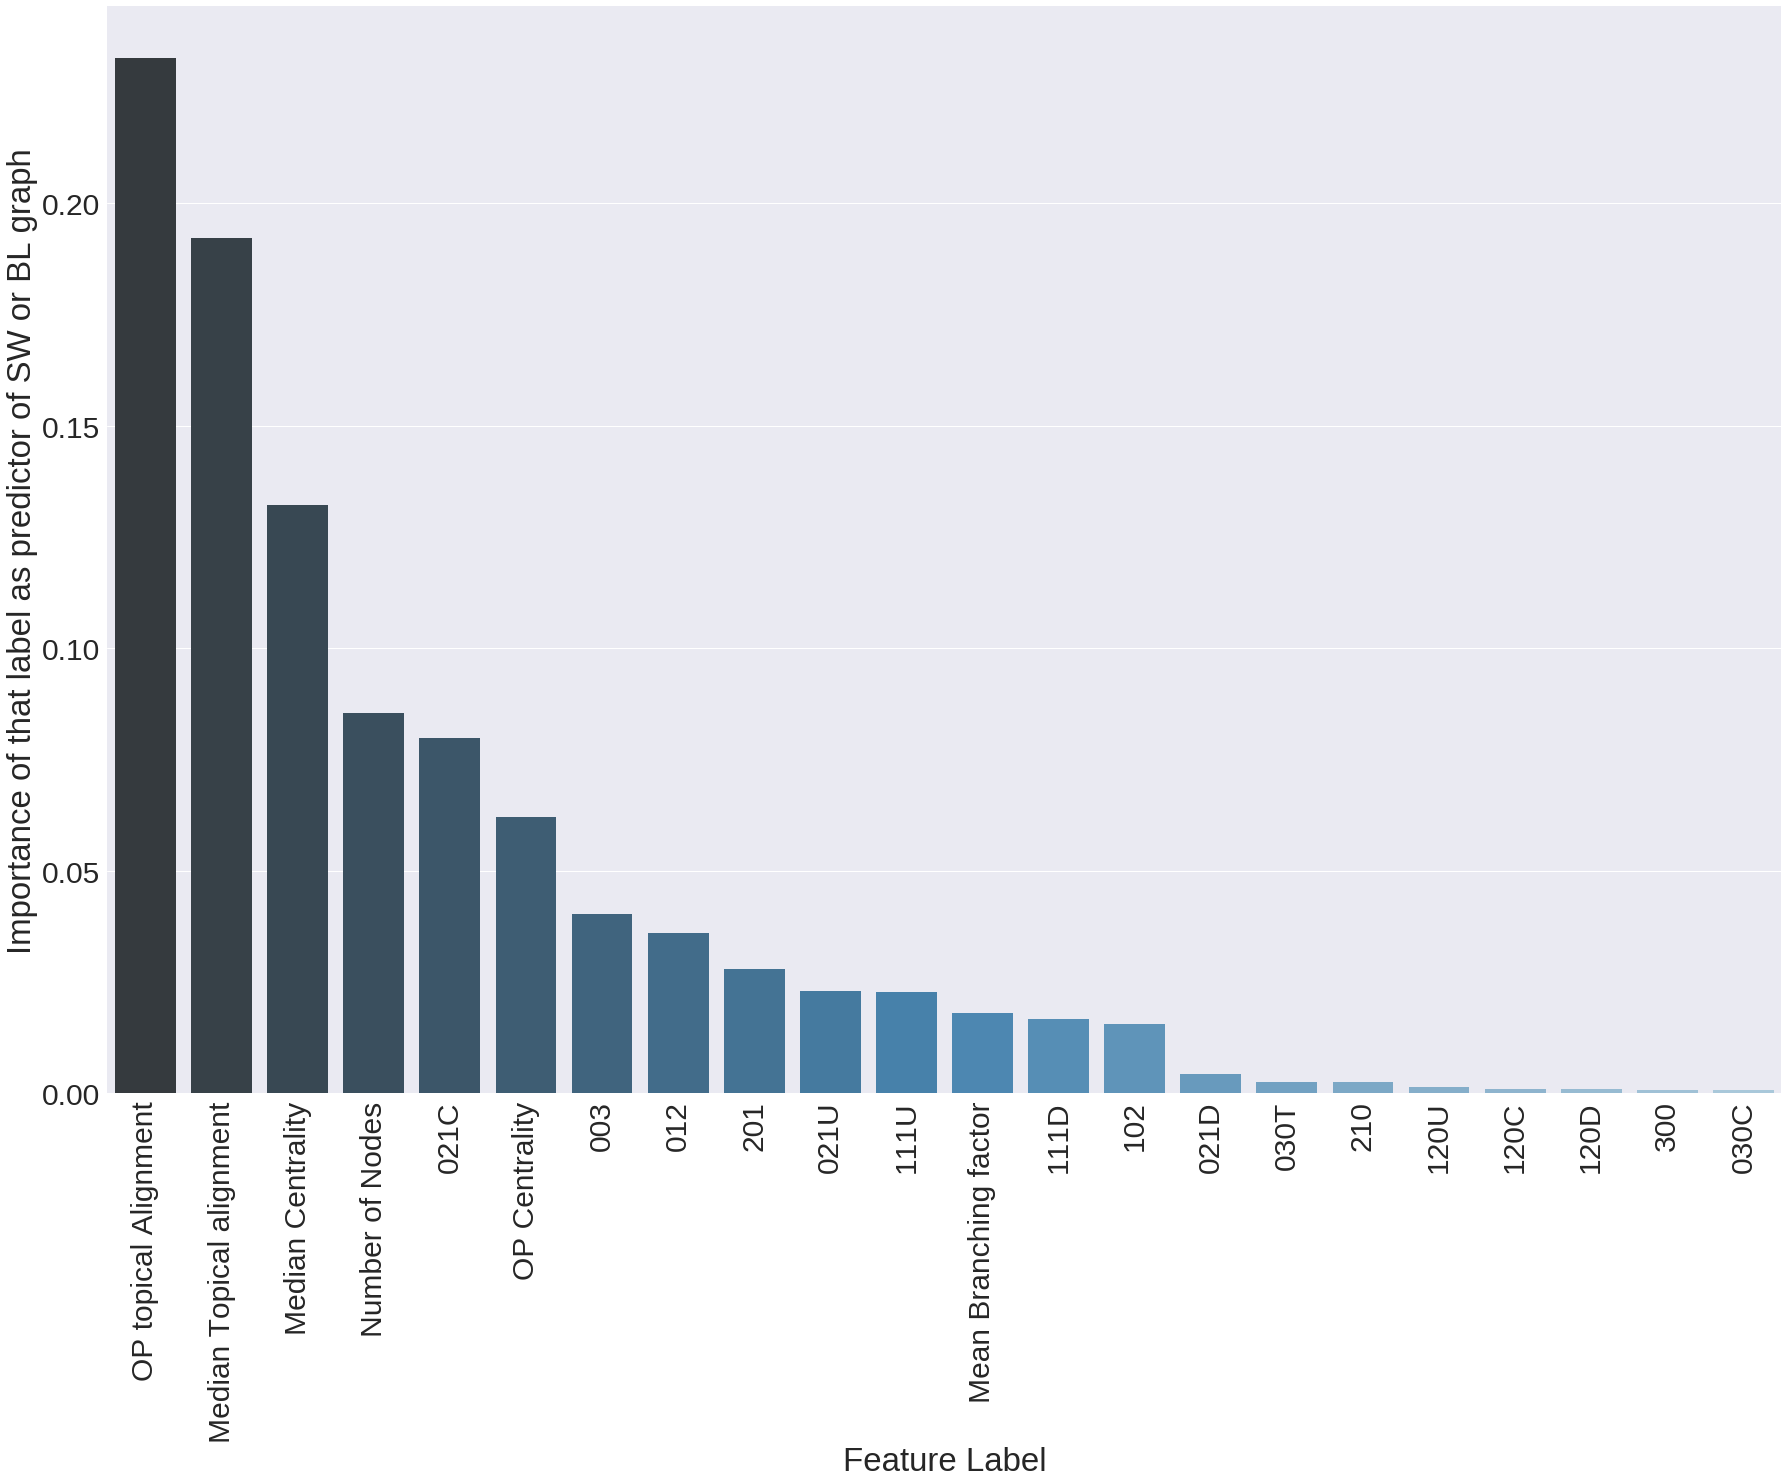

In [42]:

fig, ax = plt.subplots(figsize=(30,20))

sns.set_style("whitegrid")
#sns.set(rc={"figure.figsize": (20, 14)})
sns.set(font_scale=3) 
sns.barplot(ax = ax , x=np.array(Xlabel), y=np.array(YFreq),palette="Blues_d")
plt.xticks(rotation=90)
ax.set(xlabel='Feature Label', ylabel='Importance of that label as predictor of SW or BL graph')

In [43]:
from sklearn.linear_model.logistic import LogisticRegression
clLR = LogisticRegression()
clLR.fit(X_train, y_train)
RF_predict = clLR.predict(X_test)


accuracy = np.mean(y_test == RF_predict)
print accuracy
precision , recall , fscore , _ = precision_recall_fscore_support(y_test, RF_predict, average='binary')
print precision, recall, fscore

0.9698199340603602
0.9668367346938775 0.9722934838378656 0.969557431568176


In [44]:
clLR.coef_

array([[-4.43966467e+00, -1.59598238e+00,  3.76873965e-01,
        -4.18683929e-02,  4.37127708e+00,  8.07362952e-01,
         1.15358798e+00,  5.41030407e-01,  1.42118674e-01,
        -9.19264259e-02,  1.62984111e+00,  4.37248515e-02,
         2.18394788e-01, -9.47329703e-03,  1.62606010e-01,
         7.71395552e-03, -3.25019080e-02,  4.38078578e+00,
         6.47537310e+00, -1.15839638e+01, -1.05145112e+01,
         5.06558103e-02]])

In [45]:
coef_indices = np.argsort(clLR.coef_[0])[::-1]
Xlabel = [names[l] for l in coef_indices]
YFreq = [clLR.coef_[0][l] for l in coef_indices]

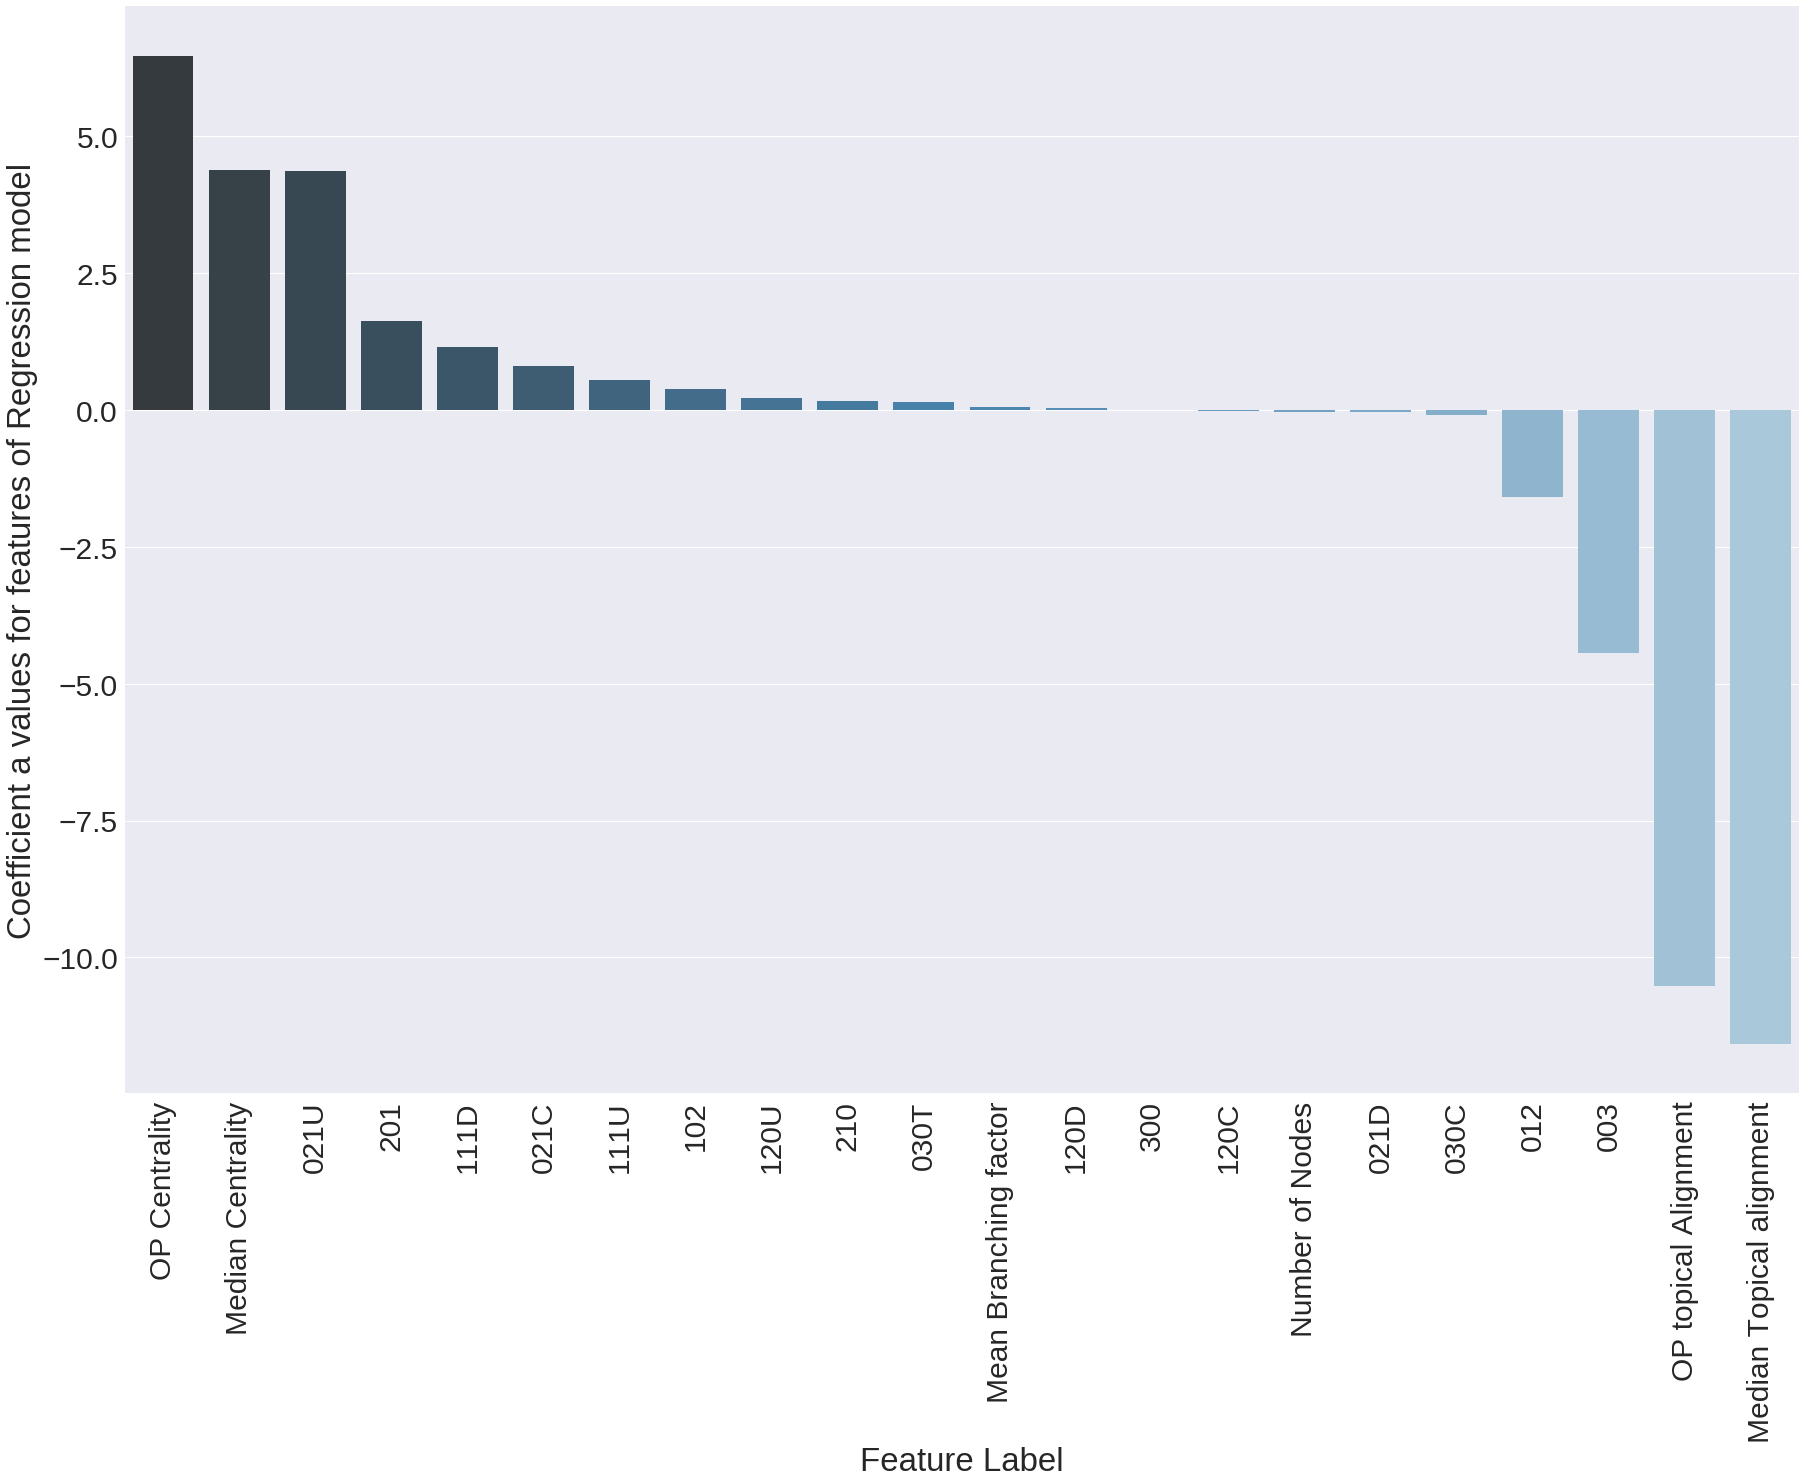

In [63]:
names = ['003', '012', '102', '021D', '021U', '021C', '111D', '111U','030T', '030C', '201', '120D', '120U', '120C', '210', '300' , 'Number of Nodes', 'Median Centrality' ,'OP Centrality' , 'Median Topical alignment' , 'OP topical Alignment' , 'Mean Branching factor' ]     
fig, ax = plt.subplots(figsize=(30,20))

sns.set_style("whitegrid")
#sns.set(rc={"figure.figsize": (20, 14)})
sns.set(font_scale=3) 
sns.barplot(ax = ax , x=np.array(Xlabel), y=np.array(YFreq),palette="Blues_d")
plt.xticks(rotation=90)
ax.set(xlabel='Feature Label', ylabel='Coefficient a values for features of Regression model')

In [47]:
index = ['Row'+str(i) for i in range(1, len(featMat)+1)]

In [48]:
import pandas as pd
df = pd.DataFrame(featMat[:,:-1], index=index)

In [54]:
# df

In [50]:
corr = df.corr()
corr = corr.as_matrix()
print corr.shape

(22, 22)


In [51]:
np.fill_diagonal(corr,0.0)
print corr.shape

(22, 22)


In [ ]:
names = ['003', '012', '102', '021D', '021U', '021C', '111D', '111U','030T', '030C', '201', '120D', '120U', '120C', '210', '300' , 'Number of Nodes', 'Median Centrality' ,'OP Centrality' , 'Median Topical alignment' , 'OP topical Alignment' , 'Mean Branching factor' ]        
print len(names)
# plot the heatmap
fig, ax = plt.subplots(figsize=(30,20))
sns.heatmap(corr, 
        xticklabels=names,
        yticklabels=names)


22


In [55]:
cov = df.cov()

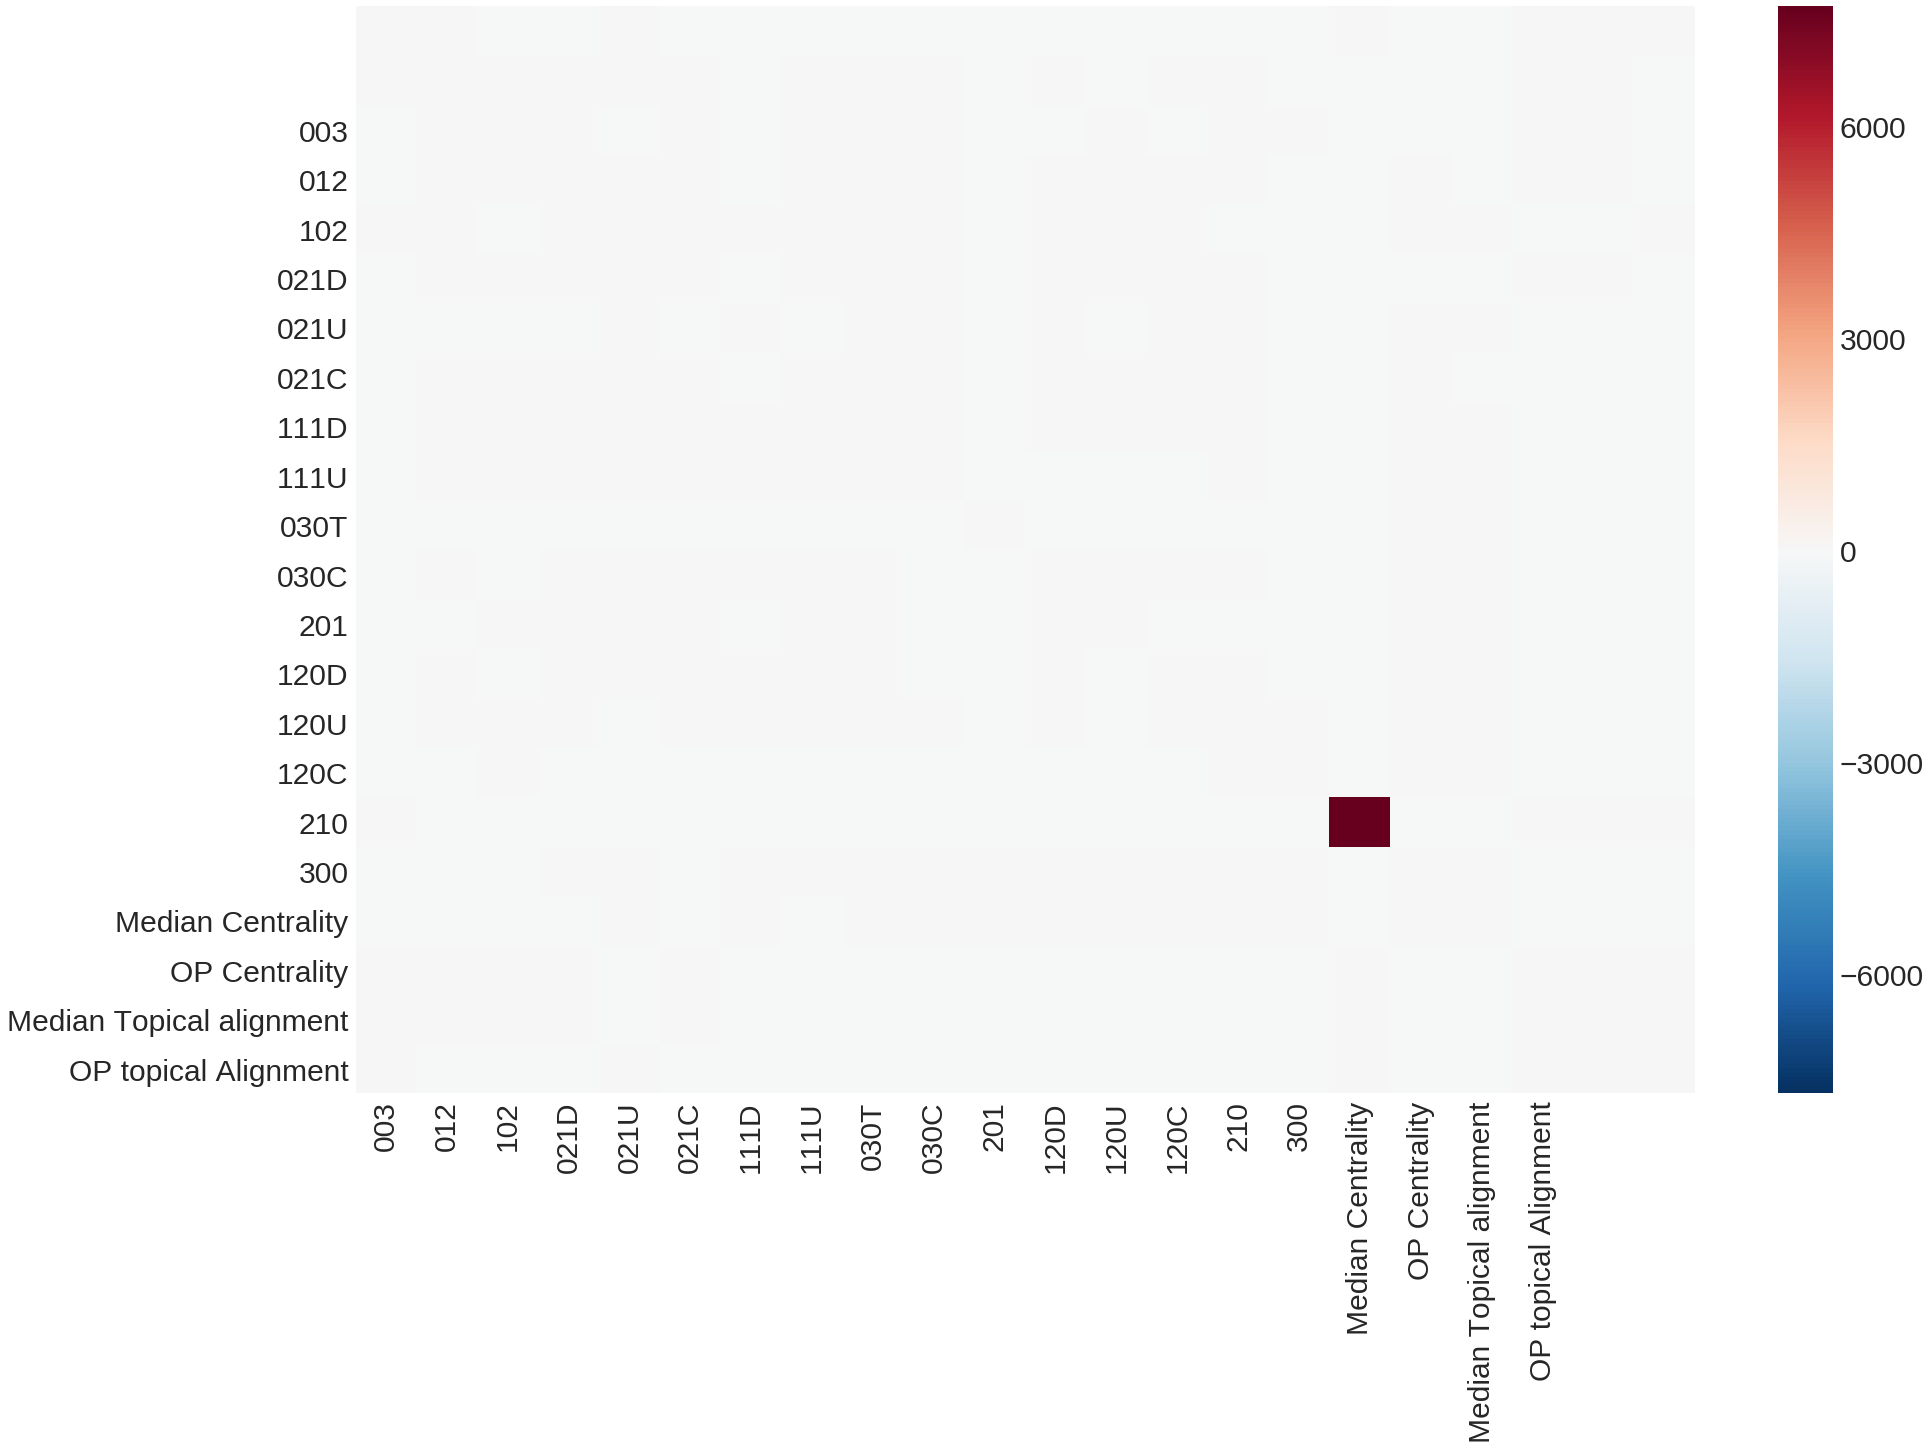

In [56]:

# plot the heatmap
fig, ax = plt.subplots(figsize=(30,20))
sns.heatmap(cov, 
        xticklabels=names,
        yticklabels=names)